<a href="https://colab.research.google.com/github/scaairesearch/da_bias_demo/blob/main/demo_bias_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Find the list of image names - folder structure for a specific condition : Done for some conditions
2.   Find conditions - pickle the dataframe / list of images
3.   Create a generic data loader to give images for specific condition (works on based on list of image, image path provided) - use class DatasetEXPWIMAGECROPRACE(Dataset): done
4.   Download model - all 3
5.   Run performance on the images based on dataloader
6.   Develop gradio app
7.   deploy gradio app
8.   look at GradCam



Demo - Bias

### Installing and importing Libraries

In [1]:
!pip install facenet-pytorch gradio

In [2]:
# install general libraries
import os
# import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

# from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision import transforms
import torch
from PIL import Image
from facenet_pytorch import MTCNN

from torch.autograd import Function
import torch.nn.functional as F
import gradio as gr
from collections import OrderedDict


In [3]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

 Cuda Status : False
cpu


In [4]:
mtcnn = MTCNN(image_size=224, device= device) # default is 224, now no need to mention later on

### Loading CSV Files
These are result files based on validation results

In [5]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Google Drive is already mounted.


In [6]:
# base_dir = ""
non_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
ewc_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])

In [7]:
# Rename the last column in each dataframe
non_dann_result.rename(columns={'p_emotion': 'p_emotion_non_dann'}, inplace=True)
dann_result.rename(columns={'p_emotion': 'p_emotion_dann'}, inplace=True)
ewc_dann_result.rename(columns={'p_emotion': 'p_emotion_ewc_dann'}, inplace=True)

In [8]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion_non_dann
167,167,afraid_African_214.jpg,Fear,African,Fear
2502,2502,afraid_american_238.jpg,Surprise,African,Fear
2069,2069,afraid_asian_103.jpg,Happy,Asian,Angry
1006,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral
2424,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral
...,...,...,...,...,...
4325,4325,unhappy_expression_537.jpg,Happy,White,Sad
2049,2049,unhappy_expression_643.jpg,Disgust,White,Disgust
8202,8202,unhappy_expression_730.jpg,Neutral,Asian,Disgust
8344,8344,unhappy_expression_749.jpg,Disgust,White,Happy


In [9]:
merged_df = non_dann_result.merge(dann_result, on=['image', 'gt_emotion', 'gt_race']).merge(ewc_dann_result, on=['image', 'gt_emotion', 'gt_race'])
merged_df.shape, merged_df.columns

((8458, 9),
 Index(['Unnamed: 0_x', 'image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'Unnamed: 0_y', 'p_emotion_dann', 'Unnamed: 0', 'p_emotion_ewc_dann'],
       dtype='object'))

In [10]:
merged_df.head()

,Unnamed: 0_x,image,gt_emotion,gt_race,p_emotion_non_dann,Unnamed: 0_y,p_emotion_dann,Unnamed: 0,p_emotion_ewc_dann
0,167,afraid_African_214.jpg,Fear,African,Fear,4064,Neutral,7694,Neutral
1,2502,afraid_american_238.jpg,Surprise,African,Fear,174,Neutral,293,Fear
2,2069,afraid_asian_103.jpg,Happy,Asian,Angry,4002,Angry,2763,Angry
3,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral,845,Neutral,7041,Neutral
4,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral,4416,Neutral,7260,Neutral


In [11]:
merged_df = merged_df[['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann', 'p_emotion_dann', 'p_emotion_ewc_dann']]

In [12]:
merged_df.shape, merged_df.columns,merged_df.head()

((8458, 6),
 Index(['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'p_emotion_dann', 'p_emotion_ewc_dann'],
       dtype='object'),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 0   afraid_African_214.jpg       Fear  African               Fear   
 1  afraid_american_238.jpg   Surprise  African               Fear   
 2     afraid_asian_103.jpg      Happy    Asian              Angry   
 3     afraid_asian_336.jpg   Surprise    Asian            Neutral   
 4     afraid_asian_367.jpg   Surprise    Asian            Neutral   
 
   p_emotion_dann p_emotion_ewc_dann  
 0        Neutral            Neutral  
 1        Neutral               Fear  
 2          Angry              Angry  
 3        Neutral            Neutral  
 4        Neutral            Neutral  )

## Dataframes based on Conditions
1. Images that are ok in non_dann, dann, dann_ewc
2. Images that are nok in non_dann, ok in dann and dann_ewc
3. Images that are nok in non_dann, nok in dann and ok in dann_ewc
4. Images that are nok in non_dann, dann_ewc but ok in dann
5. Images which are non_ok on all 3

### Condition 1: Images that are predicted same in non_dann, dann, dann_ewc, ground truth

In [13]:
condition_1 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [14]:
filtered_df_condition_1 = merged_df[condition_1]
filtered_df_condition_1.shape, filtered_df_condition_1.head()

((1805, 6),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 5      afraid_asian_39.jpg    Neutral    Asian            Neutral   
 32  amazed_African_145.jpg      Happy  African              Happy   
 38  amazed_African_253.jpg      Happy  African              Happy   
 40   amazed_African_28.jpg      Happy  African              Happy   
 41  amazed_African_293.jpg    Neutral  African            Neutral   
 
    p_emotion_dann p_emotion_ewc_dann  
 5         Neutral            Neutral  
 32          Happy              Happy  
 38          Happy              Happy  
 40          Happy              Happy  
 41        Neutral            Neutral  )

In [15]:
# df_merged_per_race = merged_df.groupby('gt_race').size().reset_index(name='merged_count')

In [16]:
# filtered_df_condition_1_per_race= filtered_df_condition_1.groupby('gt_race').size().reset_index(name='condition_1_count')

In [17]:
def race_proportion(base_df, condition_df, column_name = 'gt_race'):#, column_name):
  base_df_col = f'{column_name}'+'_base'
  condition_df_col = f'{column_name}'+'_condition'
  base_df_per_column_name = base_df.groupby(column_name).size().reset_index(name=base_df_col)
  condition_df_per_column_name = condition_df.groupby(column_name).size().reset_index(name=condition_df_col)
  merged_df = base_df_per_column_name.merge(condition_df_per_column_name, on=column_name)


  merged_df[condition_df_col] =   merged_df[condition_df_col].fillna(0)
  # # merged_df[merged_df.columns[-1]] =   merged_df[merged_df.columns[-1]].fillna(0)
  proportion_col = f'{column_name}'+'_proportion'
  merged_df[proportion_col] = round(merged_df[condition_df_col] *100/ merged_df[base_df_col],2)
  print(merged_df.head())

  return merged_df
  # merged_df[] = merged_df[column_name].fillna(0)
  # print(merged_df.head())

In [18]:
race_proportion(merged_df, filtered_df_condition_1)

          gt_race  gt_race_base  gt_race_condition  gt_race_proportion
0         African           814                164               20.15
1           Asian          1072                212               19.78
2          Indian           580                102               17.59
3          Latino           194                 70               36.08
4  Middle Eastern           202                 33               16.34


,gt_race,gt_race_base,gt_race_condition,gt_race_proportion
0,African,814,164,20.15
1,Asian,1072,212,19.78
2,Indian,580,102,17.59
3,Latino,194,70,36.08
4,Middle Eastern,202,33,16.34
5,White,5596,1224,21.87


In [19]:
# race_proportion(df_merged_per_race,filtered_df_condition_1_per_race)

### Condition 2: Images that are nok in non_dann, ok in dann and dann_ewc

In [20]:
condition_2 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [21]:
filtered_df_condition_2 = merged_df[condition_2]
filtered_df_condition_2.shape, filtered_df_condition_2.head()

((278, 6),
                       image gt_emotion  gt_race p_emotion_non_dann  \
 18        afraid_man_41.jpg    Neutral  African            Disgust   
 31   amazed_African_141.jpg    Neutral  African            Disgust   
 242    amazed_black_160.jpg    Neutral  African                Sad   
 247    amazed_black_243.jpg    Neutral   Latino              Angry   
 267     amazed_boss_204.jpg      Angry    Asian              Happy   
 
     p_emotion_dann p_emotion_ewc_dann  
 18         Neutral            Neutral  
 31         Neutral            Neutral  
 242        Neutral            Neutral  
 247        Neutral            Neutral  
 267          Angry              Angry  )

## Generic Dataset and Dataloader creator

In [22]:
GDRIVE_FOLDER = '/content/gdrive/MyDrive/CV_FER'
RACEDS_PATH = Path(GDRIVE_FOLDER,'dataset','RaceTest_EXPW','EXPW_annotated')

/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW/EXPW_annotated/Angry/Indian/mad_woman_95.jpg


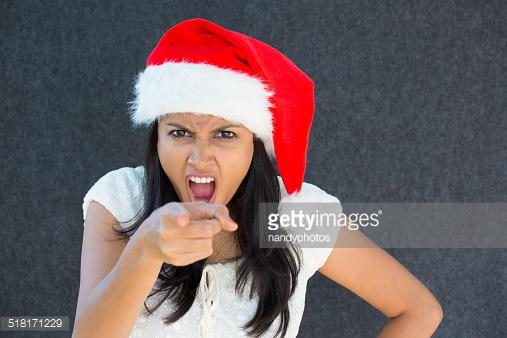

In [23]:
emotion = 'Angry'
race = 'Indian'
image_file_name = 'mad_woman_95.jpg'
image_full_path = Path(RACEDS_PATH,emotion,race,image_file_name)
print(image_full_path)
img = Image.open(image_full_path).convert("RGB")
img

In [24]:
# self.mtcnn = MTCNN(image_size=224, device= self.device)
img_cropped = mtcnn(img)
img_cropped

tensor([[[ 0.7852,  0.7852,  0.7930,  ...,  0.8867,  0.8867,  0.8867],
         [ 0.7852,  0.7852,  0.7930,  ...,  0.8867,  0.8867,  0.8867],
         [ 0.7930,  0.7930,  0.8008,  ...,  0.8867,  0.8867,  0.8867],
         ...,
         [ 0.4023,  0.4023,  0.4180,  ..., -0.8320, -0.8398, -0.8398],
         [ 0.4258,  0.4258,  0.4414,  ..., -0.8242, -0.8398, -0.8398],
         [ 0.4336,  0.4336,  0.4492,  ..., -0.8242, -0.8398, -0.8398]],

        [[ 0.8555,  0.8555,  0.8477,  ...,  0.8945,  0.8945,  0.8945],
         [ 0.8555,  0.8555,  0.8477,  ...,  0.8945,  0.8945,  0.8945],
         [ 0.8633,  0.8633,  0.8555,  ...,  0.8945,  0.8945,  0.8945],
         ...,
         [ 0.5117,  0.5117,  0.5195,  ..., -0.8789, -0.8711, -0.8711],
         [ 0.5195,  0.5195,  0.5273,  ..., -0.8711, -0.8711, -0.8711],
         [ 0.5273,  0.5273,  0.5352,  ..., -0.8633, -0.8711, -0.8711]],

        [[ 0.9102,  0.9102,  0.9102,  ...,  0.9102,  0.9102,  0.9102],
         [ 0.9102,  0.9102,  0.9102,  ...,  0

In [25]:
print(torch.min(img_cropped), torch.max(img_cropped))
image_cropped_rescaled = (img_cropped + 1) / 2
print(torch.min(image_cropped_rescaled), torch.max(image_cropped_rescaled))
image_cropped_rescaled.shape

tensor(-0.9961) tensor(0.9961)
tensor(0.0020) tensor(0.9980)


torch.Size([3, 224, 224])

In [26]:
def show_image(image_tensor):
  image_tensor_np = image_tensor.numpy()
  # print("before", image_tensor_np.shape)
  image_tensor_np = image_tensor_np.squeeze()
  # print("post squeeze", image_tensor_np.shape)

  # Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
  image_tensor_np = np.transpose(image_tensor_np, (1, 2, 0))
  # print("after", image_tensor_np.shape)

  # Display the image using Matplotlib
  plt.imshow(image_tensor_np)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  # img

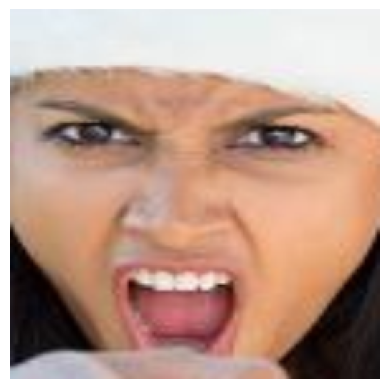

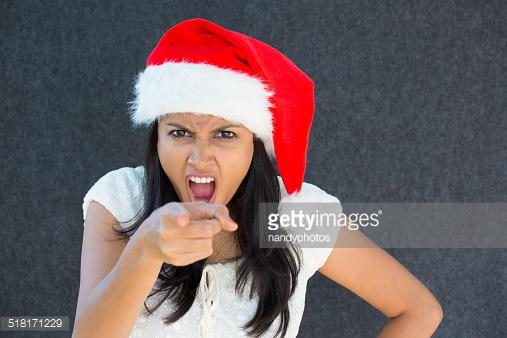

In [27]:
# Convert the tensor to a numpy array
image_cropped_np = image_cropped_rescaled.numpy()

# Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
image_cropped_np = np.transpose(image_cropped_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_cropped_np)
plt.axis('off')  # Turn off axis labels
plt.show()
img

In [28]:
import torch

# Define the labels map
labels_map = {
    "0": "angry",
    "1": "disgust",
    "2": "fear",
    "3": "happy",
    "4": "sad",
    "5": "surprise",
    "6": "neutral"
}

cpu_batch_size = 3

# List of labels
labels = list(labels_map.values())

# Create the one-hot encoding matrix
label_matrix = torch.eye(len(labels))

# Function to get the one-hot vector for a specific emotion
def get_one_hot_vector(emotion, labels = labels, label_matrix= label_matrix):
    if emotion in labels:
        idx = labels.index(emotion)
        return label_matrix[idx]
    else:
        raise ValueError(f"Emotion '{emotion}' not found in labels.")

In [29]:
# for _,emotion in labels_map.items():
#   print(get_one_hot_vector(emotion))

In [30]:
# label_matrix[1,:]== label_matrix[1]
# print(label_matrix[1,:],label_matrix[1])

In [31]:

class CustomImageDataset(Dataset):
    def __init__(self, dataframe,
                 transform=None,
                 datafolder_path = RACEDS_PATH,
                 image_file_colname = 'image',
                 race_colname  = 'gt_race',
                 gt_emotion_colname  = 'gt_emotion'):
        self.dataframe = dataframe.reset_index(drop=True)
        self.basic_transform = transforms.Compose([transforms.Resize(224),
                                                   transforms.ToTensor()])
        self.transform = transform
        self.image_file_colname = image_file_colname
        self.race_colname = race_colname
        self.gt_emotion_colname = gt_emotion_colname

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_filename = self.dataframe.loc[idx, self.image_file_colname]
        race = self.dataframe.loc[idx, self.race_colname]
        emotion = self.dataframe.loc[idx, self.gt_emotion_colname]
        emotion_one_hot = get_one_hot_vector(emotion.lower()) # emotion.lower() to match the labels

        image_full_path = Path(RACEDS_PATH,emotion,race,img_filename)

        image = Image.open(image_full_path).convert("RGB")
        cropped_image = mtcnn(image) # mtcnn takes in PIL, returns tensor in cropped image 3x224x224

        if self.transform:
          image_transformed = self.transform(image) # original image, this converts PIL into tensor
        else:
          image_transformed = self.basic_transform(image) # original image, this converts PIL into tensor

        if cropped_image is None: #error in cropping
          # in case of error, original image is returned
          return image_transformed, emotion_one_hot, image_transformed, race
        else: # cropping went ok
          # cropped image alongside original image is returned, there is no transform on cropped image.
          cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
          return cropped_image, emotion_one_hot, image_transformed, race


In [32]:
# Define  transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Create an instance of your custom dataset
dataset = CustomImageDataset(dataframe=filtered_df_condition_1, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=cpu_batch_size, shuffle=True)

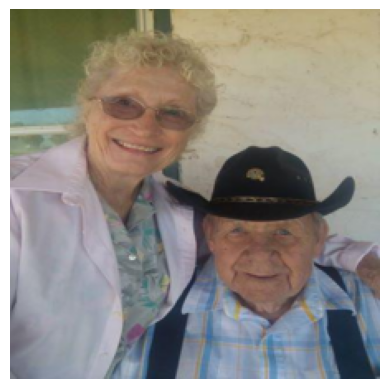

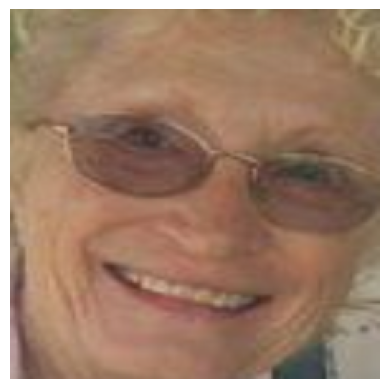

tensor([0., 0., 0., 1., 0., 0., 0.]) happy
White


In [33]:
# Example of iterating through the DataLoader
for batch in dataloader:
    cropped_images, emotions, images, races = batch
    cropped_image, emotion, image, race = cropped_images[0], emotions[0], images[0], races[0]
    show_image (image)
    show_image(cropped_image)
    print(emotion , labels_map[str(emotion.argmax().item())])
    print(race)
    break

## Network

### Pre-trained network

In [34]:
class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [35]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [36]:
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network---------------#

        list_feature_extractor = list(model_pretrained.children())[:-4]
        self.feature_extractor = nn.Sequential(*list_feature_extractor)

        #---------------------Class Classifier------------------------#

        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        self.class_classifier = nn.Sequential(*list_class_classifer)

        #---------------------Domain Classifier-----------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [37]:
model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)

In [38]:
model = model.to(device=device)

## Downloading Models

In [39]:
MODEL_DIR = Path(GDRIVE_FOLDER,"models") # for drive
non_dann_model_name = 'non_dann_sfew_expw_23_05_wo_se_a.pt'
dann_model_name = 'dann_sfew_expw_23_05_wo_se_a.pt'
ewc_dann_model_name = 'ewc_dann_sfew_expw_23_05_wo_se_a.pt'

### Non-DANN Model

In [40]:
NON_DANN_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_sfew_expw', non_dann_model_name))
print(NON_DANN_MODEL_PATH)
non_dann_model_sfew_expw_inference =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
non_dann_model_sfew_expw_inference.load_state_dict(torch.load(NON_DANN_MODEL_PATH,map_location=torch.device(device)))
# non_dann_model_sfew_expw_inference.eval()

/content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw/non_dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

### DANN Model

In [41]:
DANN_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'dann_sfew_expw', dann_model_name))
print(DANN_MODEL_PATH)
dann_model_sfew_expw_inference =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
dann_model_sfew_expw_inference.load_state_dict(torch.load(DANN_MODEL_PATH,map_location=torch.device(device)))
# dann_model_sfew_expw_inference.eval()

/content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

### EWC DANN Model

In [42]:
EWC_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'ewc_dann_sfew_expw', ewc_dann_model_name))
print(EWC_MODEL_PATH)
ewc_dann_model_sfew_expw_inference =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(EWC_MODEL_PATH,map_location=torch.device(device)))
# ewc_dann_model_sfew_expw_inference.to(device)

/content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

# UI

## Inference

In [60]:
transform_to_pil  = transforms.ToPILImage()
emotion_labels = [label.capitalize() for label in list(labels_map.values())]

def get_images(dataloader = dataloader):
    cropped_images, emotions, images, races = next(iter(dataloader))

    list_pil_cropped_images = [transform_to_pil(cropped_img) for cropped_img in cropped_images]
    list_pil_images = [transform_to_pil(img) for img in images]
    list_emotions = list(emotions) # list of one hot tensort
    list_emotions = [ emotion_labels[torch.argmax(emotion).item()] for emotion in emotions]

    # return list_pil_cropped_images, list(emotions), list_pil_images, list(races)
    return list_pil_cropped_images, list_emotions, list_pil_images, list(races)

In [61]:
get_images()

([<PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>],
 ['Happy', 'Happy', 'Happy'],
 [<PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>],
 ['White', 'White', 'White'])

In [45]:
list(labels_map.values())
emotion_labels = [label.capitalize() for label in list(labels_map.values())]
emotion_labels

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

### classify_image_all_models

In [58]:

emotion_labels = [label.capitalize() for label in list(labels_map.values())]

def classify_image_all_models(input_image):
    # print("-------")
    # print(input_image)
    # print(type(input_image))
    # print("-------")

    image_transforms =  transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor()
                                  ])
    transformed_image = image_transforms(input_image)
    image_tensor = transformed_image.to(device).unsqueeze(0)
    # image_tensor = input_image.to(device).unsqueeze(0)

    list_confidences = []
    for model in [non_dann_model_sfew_expw_inference, dann_model_sfew_expw_inference, ewc_dann_model_sfew_expw_inference]:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            logits, _ , _ = model((image_tensor*255))
            output = F.softmax(logits.view(-1), dim = -1)

            confidences = [(emotion_labels[i], float(output[i])) for i in range(len(emotion_labels))]
            confidences.sort(key=lambda x: x[1], reverse=True)
            confidences = OrderedDict(confidences[:2])
            label = torch.argmax(output).item()
            list_confidences.append(confidences)

    return list_confidences[0], list_confidences[1], list_confidences[2]

In [ ]:
# def get_correct_predictions(prediction, labels):
#     """
#     Function to return total number of correct predictions
#     :param prediction: Model predictions on a given sample of data
#     :param labels: Correct labels of a given sample of data
#     :return: Number of correct predictions
#     """
#     return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

# def test_model_race(model,
#                     device,
#                     test_loader,
#                     result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
#     model = model.to(device)
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#    # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(test_loader):
#         # for batch_idx, (data, target, name, race) in enumerate(test_loader): #     cropped_images, emotions, images, races = batch
#             data_plural, targets, images, races = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

#             # # Put the images and labels on the selected device
#             # data, target = data.to(device), target.to(device)

#             # Pass the images to the output and get the model predictions
#             class_outputs, _ , _ = model((data_plural*255))
#             # Sum up batch correct predictions
#             correct += get_correct_predictions(class_outputs, targets)


#     return correct, test_loss, accuracy, result


### All Together

In [62]:
with gr.Blocks() as demo:
    ################################################
    with gr.Tab("Case 1: Classification OK across Non DANN, DANN, EWC DANN"):
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview = False, rows = 2, columns = 2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Submit to Classify Image", visible = True, size ='sm')
                with gr.Row():
                    selected = gr.Number(show_label=False)


            with gr.Column(scale=1):
                    with gr.Row():
                        label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        demo.load(get_big_images, None, [gallery, imgs])

        def get_select_index(evt: gr.SelectData):
            # return evt.index,cropped_images[evt.index]
            print (list_emotions[evt.index])
            return list_emotions[evt.index],cropped_images[evt.index]


        gallery.select(get_select_index, None, [selected,cropped_image_display])

        button_classify_C1.click(fn=classify_image_all_models,
                            inputs=[cropped_image_display],
                            outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])


    ################################################
    with gr.Tab("Case 2: Classification OK across Non DANN, DANN, EWC DANN"):
        ...

    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
            )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
            )

    ################################################

demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://905dbe13063973cd96.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Happy
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://905dbe13063973cd96.gradio.live


In [34]:
with gr.Blocks() as demo:
    # with gr.Tab("Introduction"):
    #     gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
    #     gr.Markdown(
    #         '''
    #         Source - SFEW2.0
    #         -------
    #         - SFEW2.0 Details

    #         '''
    #         )
    #     gr.Markdown(
    #         '''
    #         Target - ExpW
    #         -------
    #         - ExpW Details

    #         '''
    #         )
    ################################################
    with gr.Tab("Case 1: Classification OK across Non DANN, DANN, EWC DANN"):
        list_pil_cropped_images, list_emotions, list_pil_images, list_races = get_images()
        dict_big_to_cropped = {list_pil_images[i]: list_pil_cropped_images[i] for i in range(len(list_pil_images))}

        def handle_image_select(big_img):
            cropped_img = dict_big_to_cropped[big_img]
            return cropped_img

        with gr.Row():
            with gr.Column():
                big_image_gallery = gr.Gallery(list_pil_images, label="Big Images", show_label=True)

                # input_image_classify_c1 = gr.Image(label="Classify Emotion", type = "pil", height = 224, width = 224)
            with gr.Column():
                cropped_image_display = gr.Image(label="Cropped Face", type = "pil", height = 224, width = 224)

                # input_cropped_image_classify_c1 = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)

            button_classify_c1 = gr.Button("Submit to Classify", visible = True, size ='sm')

            with gr.Column():
                with gr.Row():
                    label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


        big_image_gallery.select(fn=handle_image_select,
                                 inputs=[big_image_gallery],
                                 outputs=[cropped_image_display])

        button_classify_c1.click(fn=classify_image_all_models,
                    inputs=[cropped_image_display],
                    outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])

        # with gr.Row():
        #     gr.Examples(batch[2],inputs=[input_image_classify_c1], label = "Select an example Image") #working

        # with gr.Row():
        #     gr.Examples(batch[0],inputs=[input_cropped_image_classify_c1], label = "Select an example cropped Image") #working

        # with gr.Row():
        #     gr.Examples(mnist_m_images_1,inputs=[input_image_classify_c1], label = "Select an example Image") #working

        # with gr.Row():
        #     gr.Markdown(value = f'Ground Truth Emotion = {[label for label in mnist_m_labels_1]}')

        button_classify_c1.click(fn=classify_image_all_models,
                            inputs=[input_image_classify_c1],
                            outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])

    ################################################
    with gr.Tab("TAB 2: Case 1: Classification OK across Non DANN, DANN, EWC DANN"):

        with gr.Row():
            with gr.Column():
                input_image_classify_c1 = gr.Image(label="Classify Emotion", type = "pil", height = 224, width = 224)
            with gr.Column():
                input_cropped_image_classify_c1 = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)

            button_classify_c1 = gr.Button("Submit to Classify", visible = True, size ='sm')

            with gr.Column():
                with gr.Row():
                    label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)

        # mnist_m_images_1,mnist_m_labels_1 = get_images()
        batch = get_images()

        with gr.Row():
            gr.Examples(batch[2],inputs=[input_image_classify_c1], label = "Select an example Image") #working

        with gr.Row():
            gr.Examples(batch[0],inputs=[input_cropped_image_classify_c1], label = "Select an example cropped Image") #working

        # with gr.Row():
        #     gr.Examples(mnist_m_images_1,inputs=[input_image_classify_c1], label = "Select an example Image") #working

        # with gr.Row():
        #     gr.Markdown(value = f'Ground Truth Emotion = {[label for label in mnist_m_labels_1]}')

        button_classify_c1.click(fn=classify_image_all_models,
                            inputs=[input_image_classify_c1],
                            outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])

    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
            )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
            )

    ################################################

demo.launch(debug=True)


TypeError: unhashable type: 'Image'

In [56]:
import gradio as gr
import numpy as np

with gr.Blocks() as demo:
    imgs = gr.State()

    gallery = gr.Gallery(allow_preview=False)


    def generate_images():
        images = []
        for _ in range(9):
            image = np.ones((100, 100, 3), dtype=np.uint8) * np.random.randint(
                0, 255, 3
            )  # image is a solid single color
            images.append(image)
        return images, images

    demo.load(generate_images, None, [gallery, imgs])

    with gr.Row():
        selected = gr.Number(show_label=False)


    def get_select_index(evt: gr.SelectData):
        return evt.index

    gallery.select(get_select_index, None, selected)



demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e8906334fa151aa9ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### current working

In [52]:
with gr.Blocks() as demo:
    imgs = gr.State()

    # gallery = gr.Gallery(allow_preview=False)
    with gr.Row():
        with gr.Column(scale=1):
            gallery = gr.Gallery(allow_preview = False, rows = 2, columns = 2)
        with gr.Column(scale=1):
            with gr.Row():
                cropped_image_display = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)
            with gr.Row():
                button_classify_C1 = gr.Button("Submit to Classify Image", visible = True, size ='sm')
            with gr.Row():
                selected = gr.Number(show_label=False)


        with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


    cropped_images, list_emotions, big_images, list_races = get_images()

    def get_big_images():
        return big_images, big_images

    demo.load(get_big_images, None, [gallery, imgs])




    def get_select_index(evt: gr.SelectData):
        return evt.index,cropped_images[evt.index]

    gallery.select(get_select_index, None, [selected,cropped_image_display])
    # cropped_image_display.select(classify_image_all_models, None, [label_classify_non_dann,label_classify_dann,label_classify_ewc])
    button_classify_C1.click(fn=classify_image_all_models,
                          inputs=[cropped_image_display],
                          outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])


demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1f85aff0e4b5871bbb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


-------
<PIL.Image.Image image mode=RGB size=224x224 at 0x7B7FFD0C3E20>
<class 'PIL.Image.Image'>
-------
-------
<PIL.Image.Image image mode=RGB size=224x224 at 0x7B7FFD0AF820>
<class 'PIL.Image.Image'>
-------
-------
<PIL.Image.Image image mode=RGB size=224x224 at 0x7B7FFD0C35B0>
<class 'PIL.Image.Image'>
-------
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1f85aff0e4b5871bbb.gradio.live


In [46]:
import gradio as gr

def get_images():
    # Your logic to get big_images and cropped_images
    return cropped_images, list_emotions, big_images, list_races

def show_cropped_image(index):
    cropped_image = cropped_images[index]
    return cropped_image

# Assuming you have a function to convert PIL images to a format suitable for Gradio (e.g., numpy array)
def pil_to_gradio_format(pil_image):
    converted_image = np.array(pil_image)
    # Convert PIL image to a format compatible with Gradio (e.g., numpy array)
    return converted_image

cropped_images, _, big_images, _ = get_images()

with gr.Blocks() as demo:
    big_image_buttons = gr.Row(equal_height=True)
    cropped_image_display = gr.Image(label="Cropped Image")

    for i, big_image in enumerate(big_images):
        button = gr.Button(value=pil_to_gradio_format(big_image), interactive=True)
        button.click(fn=show_cropped_image, inputs=[i], outputs=cropped_image_display)
        big_image_buttons.append(button)

demo.launch()


AttributeError: 'int' object has no attribute '_id'

In [ ]:

# Example lists of images
big_images = ["path/to/big_image1.jpg", "path/to/big_image2.jpg"]
cropped_images = [
    ["path/to/cropped1_1.jpg", "path/to/cropped1_2.jpg"],
    ["path/to/cropped2_1.jpg", "path/to/cropped2_2.jpg"]
]

# Dictionary to map big image to its cropped images
big_to_cropped = {big_images[i]: cropped_images[i] for i in range(len(big_images))}

def update_cropped_image(big_image):
    # Get the list of cropped images for the selected big image
    cropped_list = big_to_cropped[big_image]
    # Return the first cropped image for simplicity
    return cropped_list[0]

def on_big_image_selected(big_image):
    return big_image, update_cropped_image(big_image)

# Set up the Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    big_image_dropdown = gr.Dropdown(choices=big_images, label="Select Big Image")
    big_image_display = gr.Image(label="Big Image")
    cropped_image_display = gr.Image(label="Cropped Image")

    big_image_dropdown.change(
        fn=on_big_image_selected,
        inputs=big_image_dropdown,
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4bda38c4b7de7ec266.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [43]:
import gradio as gr
from PIL import Image

# Example PIL images
cropped_images, list_emotions, big_images, list_races = get_images()

big_crop_list = []
for big_img, crop_img in zip(big_images, cropped_images):
    big_crop_list.append((big_img, crop_img))

# Use indices to map big images to their cropped images
def get_cropped_images(index):
    return cropped_images[index]

# Create a list of indices to represent the big images
indices = list(range(len(big_images)))

def on_big_image_selected(index):
    # Use index to get the big image and its cropped images
    big_image = big_images[index]
    cropped_list = get_cropped_images(index)
    return big_image, cropped_list

# Define Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    gr.Markdown("## Select a Big Image")

    with gr.Row():
        with gr.Column():
            big_image_gallery = gr.Gallery(
                value=[big_images[i] for i in indices],  # Provide PIL images for gallery
                label="Big Images",
                show_label=False
            )
        with gr.Column():
            big_image_display = gr.Image(label="Big Image")
            cropped_image_display = gr.Image(label="Cropped Image")

    def handle_image_select(index):
        return on_big_image_selected(index)

    big_image_gallery.select(
        fn=handle_image_select,
        inputs=[big_image_gallery],
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3b8204524b3a84851c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3b8204524b3a84851c.gradio.live


In [ ]:
import gradio as gr
from PIL import Image

# Example PIL images
cropped_images, list_emotions, big_images, list_races = get_images()

# Create a list of indices to represent the big images
indices = list(range(len(big_images)))

# def get_cropped_images(index):
#     return cropped_images[index]

def on_big_image_selected(index):
    # Use index to get the big image and its cropped images
    big_image = big_images[index]
    cropped_list = cropped_images[index]
    return big_image, cropped_list

# Convert PIL images to data for the gallery
big_image_data = [(img, idx) for idx, img in enumerate(big_images)]

# Define Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    gr.Markdown("## Select a Big Image")

    with gr.Row():
        with gr.Column():
            big_image_gallery = gr.Gallery(
                value=[img[0] for img in big_image_data],  # Provide PIL images for gallery
                label="Big Images",
                show_label=False
            )
        with gr.Column():
            big_image_display = gr.Image(label="Big Image")
            cropped_image_display = gr.Image(label="Cropped Image")

    def handle_image_select(selected_image):
        # Find the index of the selected image
        for img, index in big_image_data:
            print(selected_image)
            print("before checking condition index: ", img, index)

            if img == selected_image:
                print("index: ", index)
                return on_big_image_selected(index)
        return None, None

    big_image_gallery.select(
        fn=handle_image_select,
        inputs=[big_image_gallery],
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f1365ade477a6fec84.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[('/tmp/gradio/ee01bfabe97e0855c5bf7a74f8c9c0d6d03f67bd/image.webp', None), ('/tmp/gradio/6a2b8dc96c4fa9c8d8a5fb8ae936190fddcbe981/image.webp', None), ('/tmp/gradio/9711fd2d9cf4d140aa2927493b0cabebf049d603/image.webp', None)]
before checking condition index:  <PIL.Image.Image image mode=RGB size=224x224 at 0x7E5FD02B6530> 0
[('/tmp/gradio/ee01bfabe97e0855c5bf7a74f8c9c0d6d03f67bd/image.webp', None), ('/tmp/gradio/6a2b8dc96c4fa9c8d8a5fb8ae936190fddcbe981/image.webp', None), ('/tmp/gradio/9711fd2d9cf4d140aa2927493b0cabebf049d603/image.webp', None)]
before checking condition index:  <PIL.Image.Image image mode=RGB size=224x224 at 0x7E5FD02B7400> 1
[('/tmp/gradio/ee01bfabe97e0855c5bf7a74f8c9c0d6d03f67bd/image.webp', None), ('/tmp/gradio/6a2b8dc96c4fa9c8d8a5fb8ae936190fddcbe981/image.webp', None), ('/tmp/gradio/9711fd2d9cf4d140aa2927493b0cabebf049d603/image.webp', None)]
before checking condition index:  <PIL.Image.Image image mode=RGB size=224x224 at 0x7E5FD02B4310> 2
[('/tmp/gradio/ee01bfa

In [ ]:
cropped_images, list_emotions, big_images, list_races = get_images()

big_images

[<PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>]

In [ ]:
[type(img) for img in big_images]

[PIL.Image.Image, PIL.Image.Image, PIL.Image.Image]

In [ ]:
import gradio as gr
from PIL import Image
import io

# # Function to get images and other data (assuming it returns lists of PIL images and other information)
# def get_images():
#     # Dummy implementation: replace with actual image loading logic
#     big_images = [Image.open("path/to/big_image1.jpg"), Image.open("path/to/big_image2.jpg")]
#     cropped_images = [Image.open("path/to/cropped_image1.jpg"), Image.open("path/to/cropped_image2.jpg")]
#     list_emotions = ["happy", "sad"]  # Example emotions
#     list_races = ["race1", "race2"]  # Example races
#     return cropped_images, list_emotions, big_images, list_races

# Helper function to convert PIL image to a unique identifier (e.g., hash of the image bytes)
def get_image_identifier(image):
    return hash(image.tobytes())

# Get images and other data
cropped_images, list_emotions, big_images, list_races = get_images()

# Create a dictionary mapping big images to their corresponding cropped images using identifiers
big_to_cropped = {get_image_identifier(big_img): cropped_img for big_img, cropped_img in zip(big_images, cropped_images)}

# Define Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    gr.Markdown("## Select a Big Image")

    with gr.Row():
        with gr.Column():
            big_image_gallery = gr.Gallery(
                value=big_images,  # Provide PIL images for gallery
                label="Big Images",
                show_label=False
            )
        with gr.Column():
            big_image_display = gr.Image(label="Big Image")
            cropped_image_display = gr.Image(label="Cropped Image")

    def handle_image_select(selected_files):
        print(selected_files)

        selected_file = selected_files[0][0]  # Extract the first file path from the list
        print(selected_file)
        # Load the selected image from the file path
        selected_image = Image.open(selected_file)
        selected_identifier = get_image_identifier(selected_image)
        cropped_image = big_to_cropped.get(selected_identifier, None)
        return selected_image, cropped_image

    big_image_gallery.select(
        fn=handle_image_select,
        inputs=[big_image_gallery],
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f06a152ee08596c972.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[('/tmp/gradio/9486e090b70c0e779287573ea557cf76d26c835f/image.webp', None), ('/tmp/gradio/ae5b0c2f382428e8cd936b29d1f92ffc06f1ea7d/image.webp', None), ('/tmp/gradio/4cacfbe01bbf8f67bde30cdbadab5a221b818a9d/image.webp', None)]
/tmp/gradio/9486e090b70c0e779287573ea557cf76d26c835f/image.webp
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7867 <> https://f06a152ee08596c972.gradio.live


In [ ]:
import gradio as gr
from PIL import Image
import io



# Helper function to convert PIL image to a unique identifier (e.g., hash of the image bytes)
def get_image_identifier(image):
    return hash(image.tobytes())

# Get images and other data
cropped_images, list_emotions, big_images, list_races = get_images()

# Create a dictionary mapping big images to their corresponding cropped images using identifiers
big_to_cropped = {get_image_identifier(big_img): cropped_img for big_img, cropped_img in zip(big_images, cropped_images)}

# Define Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    gr.Markdown("## Select a Big Image")

    with gr.Row():
        with gr.Column():
            big_image_gallery = gr.Gallery(
                value=big_images,  # Provide PIL images for gallery
                label="Big Images",
                show_label=False
            )
        with gr.Column():
            big_image_display = gr.Image(label="Big Image")
            cropped_image_display = gr.Image(label="Cropped Image")

    def handle_image_select(selected_files):
        selected_file = selected_files[0][0]  # Extract the first file path from the list
        selected_image = Image.open(selected_file)

        # Find the index of the selected image
        selected_index = None
        for idx, img in enumerate(big_images):
            if get_image_identifier(img) == get_image_identifier(selected_image):
                selected_index = idx
                break

        if selected_index is not None:
            cropped_image = cropped_images[selected_index]
            return big_images[selected_index], cropped_image
        return None, None

    big_image_gallery.select(
        fn=handle_image_select,
        inputs=[big_image_gallery],
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c17f47a1ef07bda1d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7868 <> https://630cf5dadfdd4032df.gradio.live
Killing tunnel 127.0.0.1:7869 <> https://c17f47a1ef07bda1d1.gradio.live


In [ ]:
import gradio as gr
from PIL import Image
import io


# Helper function to convert PIL image to a unique identifier (e.g., hash of the image bytes)
def get_image_identifier(image):
    return hash(image.tobytes())

# Get images and other data
cropped_images, list_emotions, big_images, list_races = get_images()

# Create a dictionary mapping big images to their corresponding cropped images using identifiers
big_to_cropped = {get_image_identifier(big_img): cropped_img for big_img, cropped_img in zip(big_images, cropped_images)}

# Define Gradio interface using gr.Blocks
with gr.Blocks() as demo:
    gr.Markdown("## Select a Big Image")

    with gr.Row():
        with gr.Column():
            big_image_gallery = gr.Gallery(
                value=big_images,  # Provide PIL images for gallery
                label="Big Images",
                show_label=False
            )
        with gr.Column():
            big_image_display = gr.Image(label="Big Image")
            cropped_image_display = gr.Image(label="Cropped Image")

    def handle_image_select(selected_image):
        # Find the index of the selected image
        selected_index = None
        for idx, img in enumerate(big_images):
            if get_image_identifier(img) == get_image_identifier(selected_image):
                selected_index = idx
                break

        if selected_index is not None:
            cropped_image = cropped_images[selected_index]
            return selected_image, cropped_image
        return None, None

    big_image_gallery.select(
        fn=handle_image_select,
        inputs=[big_image_gallery],
        outputs=[big_image_display, cropped_image_display]
    )

# Launch the interface
demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://66025158b4a013766a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7869 <> https://fde1b81d157e4adec9.gradio.live
Killing tunnel 127.0.0.1:7870 <> https://66025158b4a013766a.gradio.live


In [ ]:
import gradio as gr
from PIL import Image


# Load images once
cropped_images, _, big_images, _ = get_images()

# Function to update cropped images based on selected big image index
def update_cropped_images(selected_images):
    if isinstance(selected_images, list) and len(selected_images) > 0:
        # Extract the index from the list of tuples
        selected_image = selected_images[0]
        index = big_images.index(selected_image[0])
        return cropped_images[index]
    return []

# Create the Gradio interface
with gr.Blocks() as demo:
    with gr.Row():
        big_image_gallery = gr.Gallery(
            value=big_images,  # Directly use PIL images
            label="Select a big image",
            columns=3,
            type="pil"
        )

        cropped_image_gallery = gr.Gallery(
            value=[],
            label="Cropped images",
            columns=4,
            type="pil"
        )

    big_image_gallery.select(
        fn=update_cropped_images,
        inputs=big_image_gallery,
        outputs=cropped_image_gallery
    )

demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f84ff362d1e4515f09.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7870 <> https://f84ff362d1e4515f09.gradio.live


In [ ]:
import gradio as gr
from PIL import Image


big_images, cropped_images = get_images()

def show_images(selected_index):
    # Function to get the images to be displayed
    selected_big_image = big_images[selected_index]
    selected_cropped_images = cropped_images[selected_index]
    return selected_big_image, selected_cropped_images

# Define Gradio interface
def update_display(index):
    big_img, cropped_imgs = show_images(index)
    return big_img, cropped_imgs

# Create Gradio components
big_image_gallery = gr.inputs.Gallery(images=big_images, label="Select a Big Image")
big_image_display = gr.outputs.Image(type="pil")
cropped_images_display = gr.outputs.Gallery(type="pil", label="Cropped Images")

gr.Interface(
    fn=update_display,
    inputs=big_image_gallery,
    outputs=[big_image_display, cropped_images_display]
).launch()
